# Pre-processing - Volve Dataset 
## Statistical Wavelet Estimation

This notebook performs the statiscal wavelet estimation on a fence along **Well NO 15 9-19 A** on the Volve dataset.

In [97]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import pylops
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *
from scipy.ndimage import gaussian_filter
from scipy.ndimage.interpolation import shift

from seis2rock.seis2rock_functions import *
from seis2rock.seis2rock_utils import *

np.random.seed(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading and visualizing data needed

In [98]:
f = np.load('../../data/Volve2dfenceby1degree_NO_15_9-19_A.npz', 
            allow_pickle=True) 

f.files

['t_seis',
 'z_vel',
 't_vrms',
 't_ainvt',
 'seismict_fence',
 'vtraces',
 'vtraces_z',
 'well_prestack',
 'zwell_seismic',
 'seismicd_prestack_fence',
 'z_seismic_prestack_fence',
 'vel_fence',
 'vrms_fence',
 'v_fence_depth',
 'aiinvt_fence',
 'horizons_fence',
 'well_tvdss',
 'well_twt',
 'well_ai',
 'well_si',
 'well_vp',
 'well_vs',
 'well_rho',
 'well_phi',
 'well_vsh',
 'well_sw',
 'well_ai_prestack_sampling',
 'well_si_prestack_sampling',
 'well_vp_prestack_sampling',
 'well_vs_prestack_sampling',
 'well_rho_prestack_sampling',
 'well_phi_prestack_sampling',
 'well_vsh_prestack_sampling',
 'well_sw_prestack_sampling',
 'well_vtrace_prestack_sampling',
 'izwellfence',
 'itwellfence',
 'depth_fence',
 'zwell',
 'xlsext',
 'ilsext']

In [99]:
t_seis = f['t_seis']
t_vrms = f['t_vrms']
t_ainvt = f['t_ainvt']
dt = t_seis[1] - t_seis[0]

seismicd_prestack_fence=f['seismicd_prestack_fence'][:,25:,:] # Just taking positive angles
z_seismic_prestack_fence=f['z_seismic_prestack_fence']
dz = z_seismic_prestack_fence[1] - z_seismic_prestack_fence[0]

vtraces = f['vtraces']
vtraces_z = f['vtraces_z']

seismic_fence = f['seismict_fence']
vrms_fence = f['vrms_fence']
v_fence_depth=f['v_fence_depth']
aiinvt_fence = f['aiinvt_fence']
x_seis = np.arange(seismicd_prestack_fence.shape[0])

horizons_fence = f['horizons_fence'][()]

well_tvdss = f['well_tvdss']
well_twt = f['well_twt']
well_ai = f['well_ai']
well_si = f['well_si']
well_vp = f['well_vp']
well_vs = f['well_vs']
well_rho = f['well_rho']
well_phi = f['well_phi']
well_vsh = f['well_vsh']
well_sw = f['well_sw']

izwellfence=f['izwellfence']
itwellfence=f['itwellfence']
depth_fence=f['depth_fence']
zwell = f['zwell']
zwell_seismic = f['zwell_seismic']

xlsext = f['xlsext']
ilsext = f['ilsext']

well_prestack = f['well_prestack']
well_ai_prestack_sampling = f['well_ai_prestack_sampling']
well_si_prestack_sampling = f['well_si_prestack_sampling']
well_vp_prestack_sampling = f['well_vp_prestack_sampling']
well_vs_prestack_sampling = f['well_vs_prestack_sampling']
well_rho_prestack_sampling = f['well_rho_prestack_sampling']

well_phi_prestack_sampling = f['well_phi_prestack_sampling']
well_vsh_prestack_sampling = f['well_vsh_prestack_sampling']
well_sw_prestack_sampling = f['well_sw_prestack_sampling']

well_vtrace_prestack_sampling= f['well_vtrace_prestack_sampling']


offset = np.load('../../data/doffset_fence_well_NO_15_9-19_BT2.npy') 
wellname = 'NO 15/9-19 A'

### Prestack Data

Let's visualize the prestack data of the entire fence and plot the well trajectory. However, it should be noted that the well log information is not available for the entire trajectory. Therefore, we will focus our analysis on a specific area that encompasses the available well log information.

(0.0, 711.0, 3996.0, 0.0)

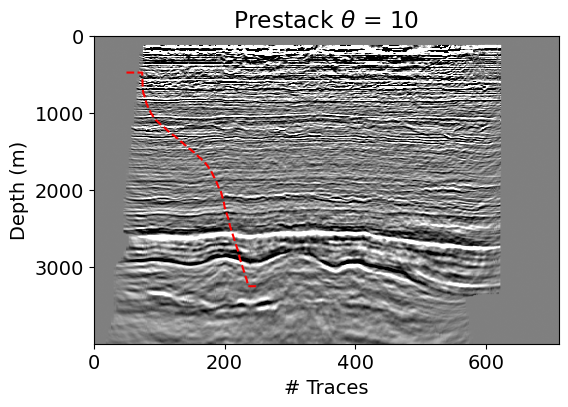

In [100]:
plt.figure(figsize=(6,4))
plt.imshow(seismicd_prestack_fence[:,10,:].T, cmap='gray', vmin=-1, vmax=1,
           extent=[0, seismicd_prestack_fence.shape[0], 
                   z_seismic_prestack_fence[-1], 
                   z_seismic_prestack_fence[0]])
# Plot the well trajectory
plt.plot(np.arange(len(zwell))[50:250], zwell[50:250], '--r')
plt.title('Prestack $\\theta$ = 10')
plt.xlabel('# Traces')
plt.ylabel('Depth (m)')
plt.axis('tight')

In [101]:
## Get the window depth for the prestack where the well log has information. 
window_min, window_max, well_start_data, well_end_data = get_depth_window_fence_Volve(well_vp_prestack_sampling=well_vp_prestack_sampling, 
                                                                                      zwell_seismic=zwell_seismic, 
                                                                                      z_seismic_prestack_fence=z_seismic_prestack_fence)

### Well log information 

Here, we will present the available well log information and the prestack data along the well

In [102]:
#Processing elastic logs
vp, vs, rho, vp_back, vs_back, rho_back = process_well_logs(log_1=well_vp_prestack_sampling, 
                                                            log_2=well_vs_prestack_sampling, 
                                                            log_3=well_rho_prestack_sampling, 
                                                            depth_min=well_start_data, 
                                                            depth_max=well_end_data,
                                                            nsmooth=40)

#If AI and SI logs are needed: 
ai = vp*rho
si = vs*rho

#Processing petrophysical logs
phi, vsh, sw, phi_back, vsh_back, sw_back = process_well_logs(log_1=well_phi_prestack_sampling, 
                                                              log_2=well_vsh_prestack_sampling, 
                                                              log_3=well_sw_prestack_sampling, 
                                                              depth_min=well_start_data, 
                                                              depth_max=well_end_data,
                                                              nsmooth=40)


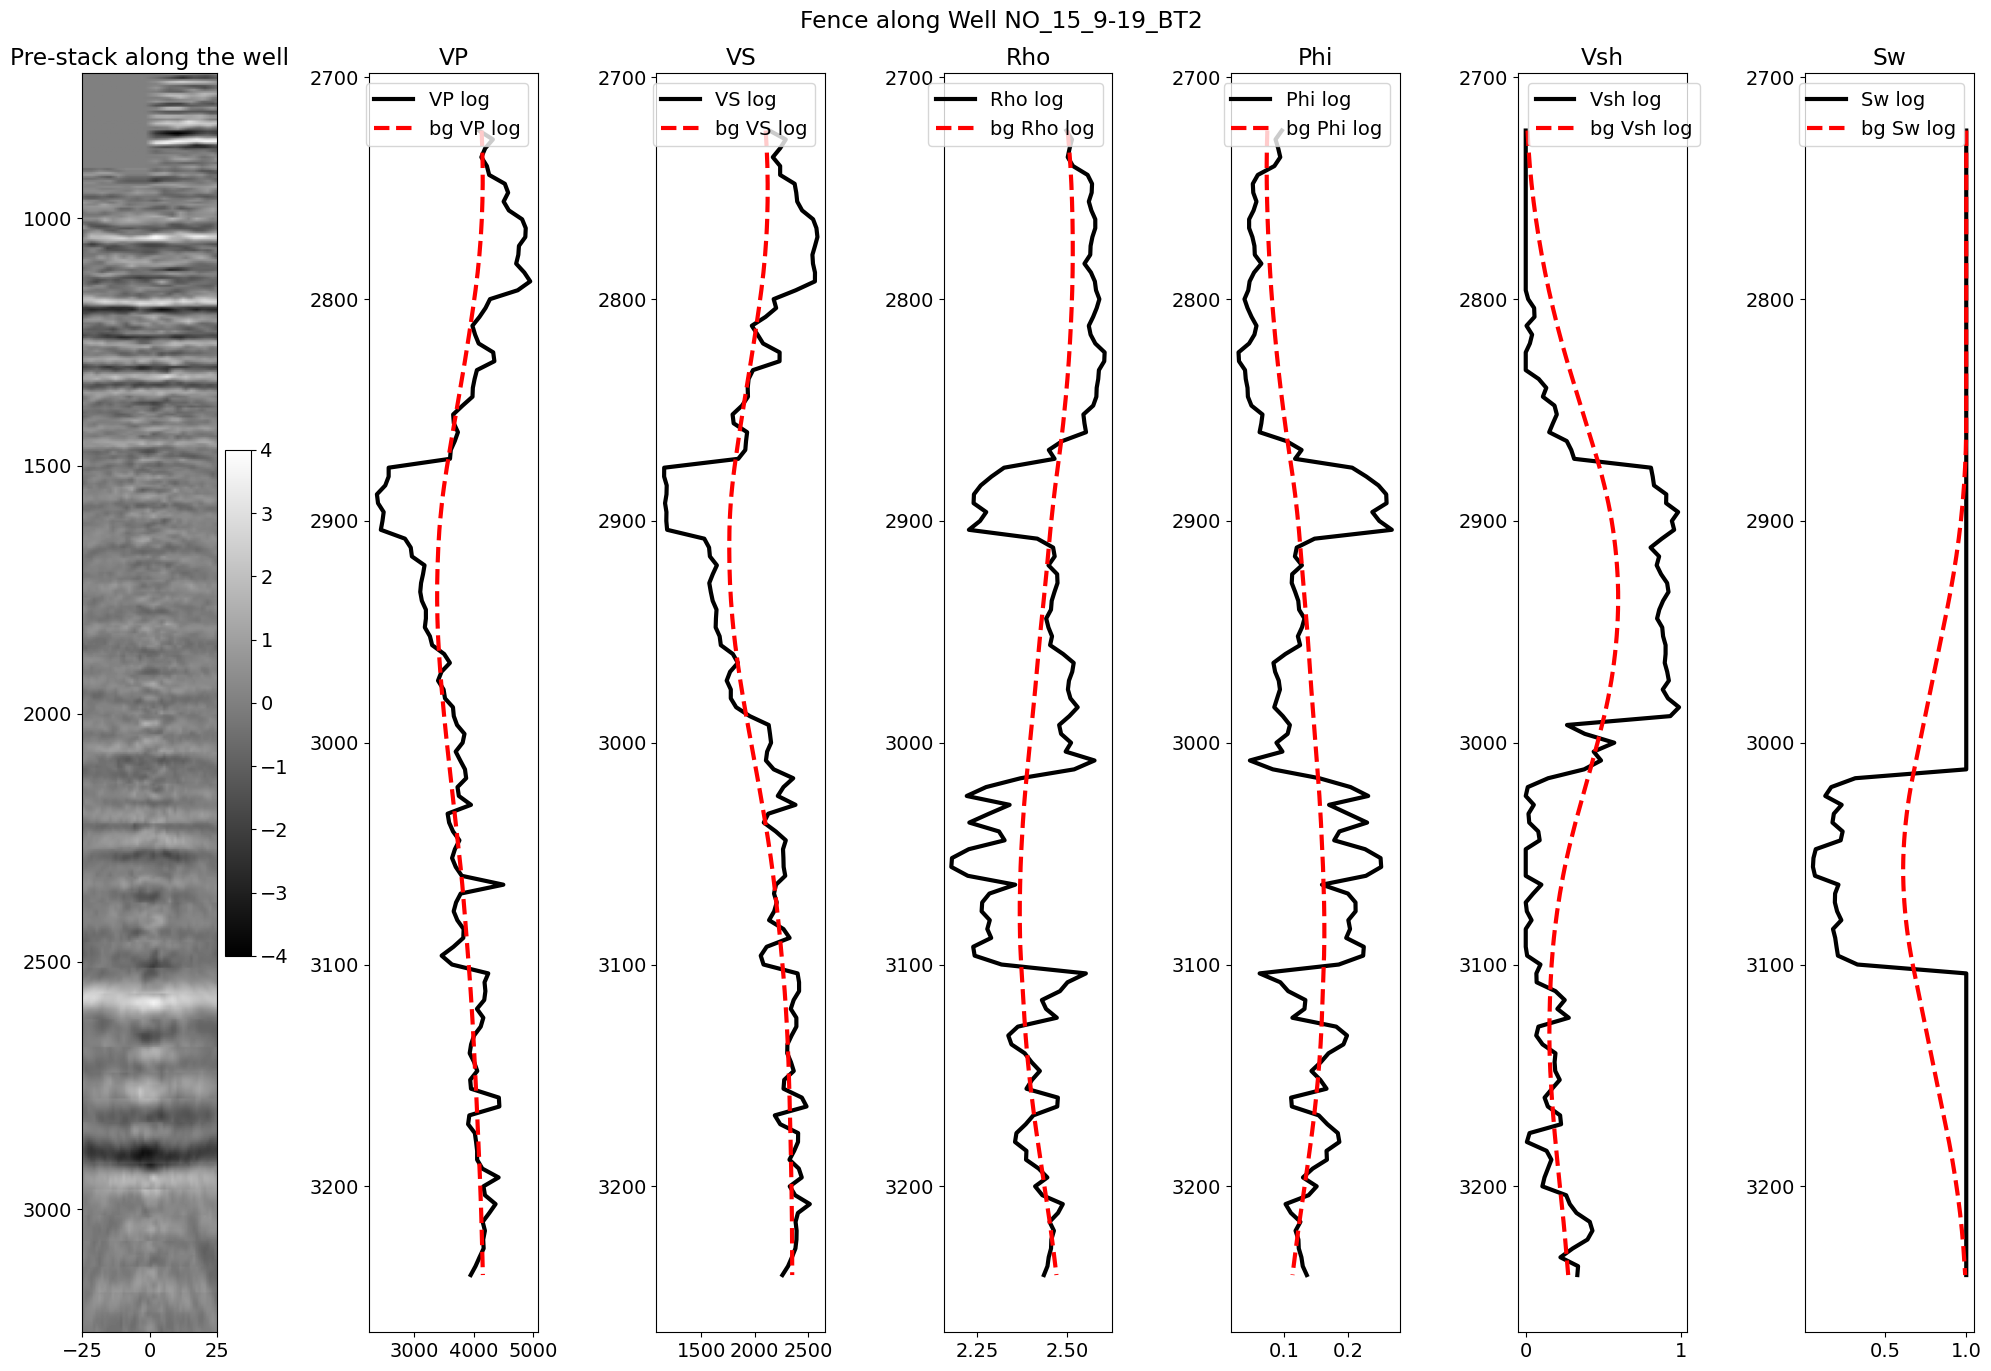

In [103]:
thetamin=-25
thetamax=25
ntheta = 50

plot_set_logs(well_name='Fence along Well NO_15_9-19_BT2', 
              well_prestack=well_prestack, 
              extent_prestack=(thetamin, thetamax, zwell_seismic[-1], zwell_seismic[0]), 
              well_depth=zwell_seismic[well_start_data:well_end_data], 
              vp=vp, 
              vs=vs, 
              rho=rho, 
              phi=phi, 
              vsh=vsh, 
              sw=sw,
              vp_back=vp_back, 
              vs_back=vs_back, 
              rho_back=rho_back,
              phi_back=phi_back, 
              vsh_back=vsh_back, 
              sw_back=sw_back, 
              figsize=(20,14))

### Wavelet estimation

First, we will estimate the wavelet of a prestack area close to the well to later on determine the wavelet scaling

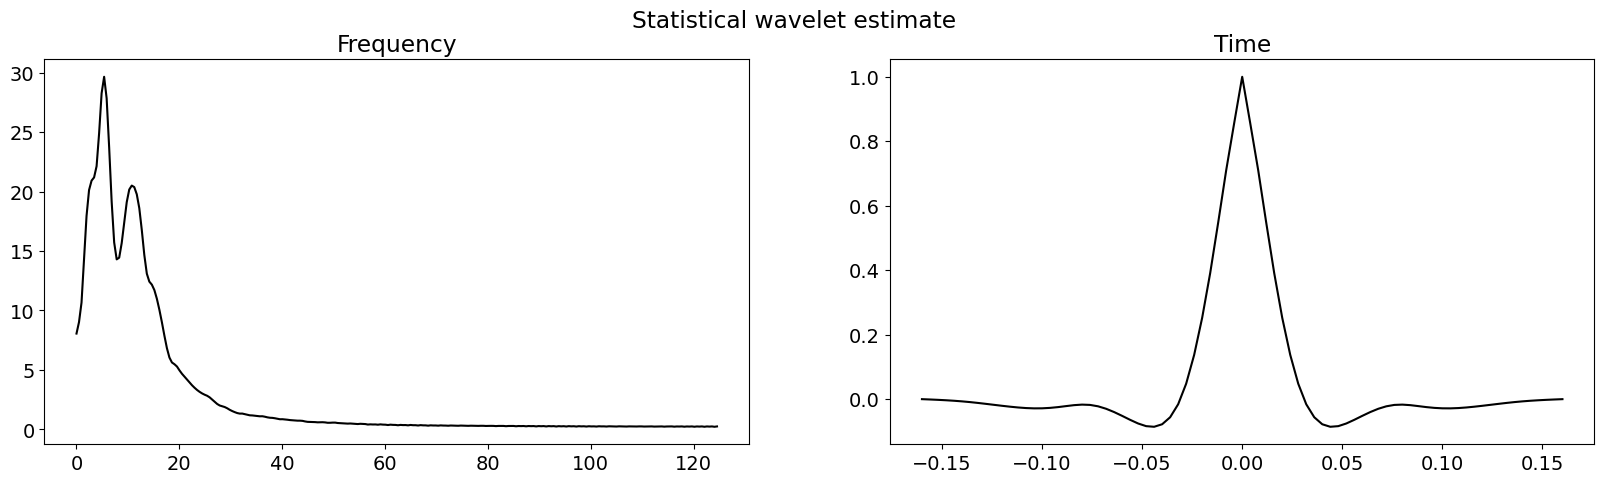

In [104]:
# Statistical Wavelet estimation
nfft = 512
nt_wav = 41
wav_scaling =1

wav_est, t_wav ,fwest, wav_est_fft = get_wavelet_estimate(nt_wav=nt_wav, nfft=nfft, wav_scaling=wav_scaling, 
                                    prestack_data=seismicd_prestack_fence[150:300,:, window_min:window_max], 
                                    dt=dt)


# Display wavelet
display_wavelet(wav_est= wav_est, fwest=fwest, wav_est_fft=wav_est_fft, 
                t_wav= t_wav, nfft=nfft, fontsize = 14)

Creting sythetic gather

In [105]:
synthetic_gather = avo_synthetic_gather(vp, vs, rho, wav_est, nt_wav, thetamin=-25, thetamax=25, ntheta=50)

Plot real and synthetic gather without wavelet scaling

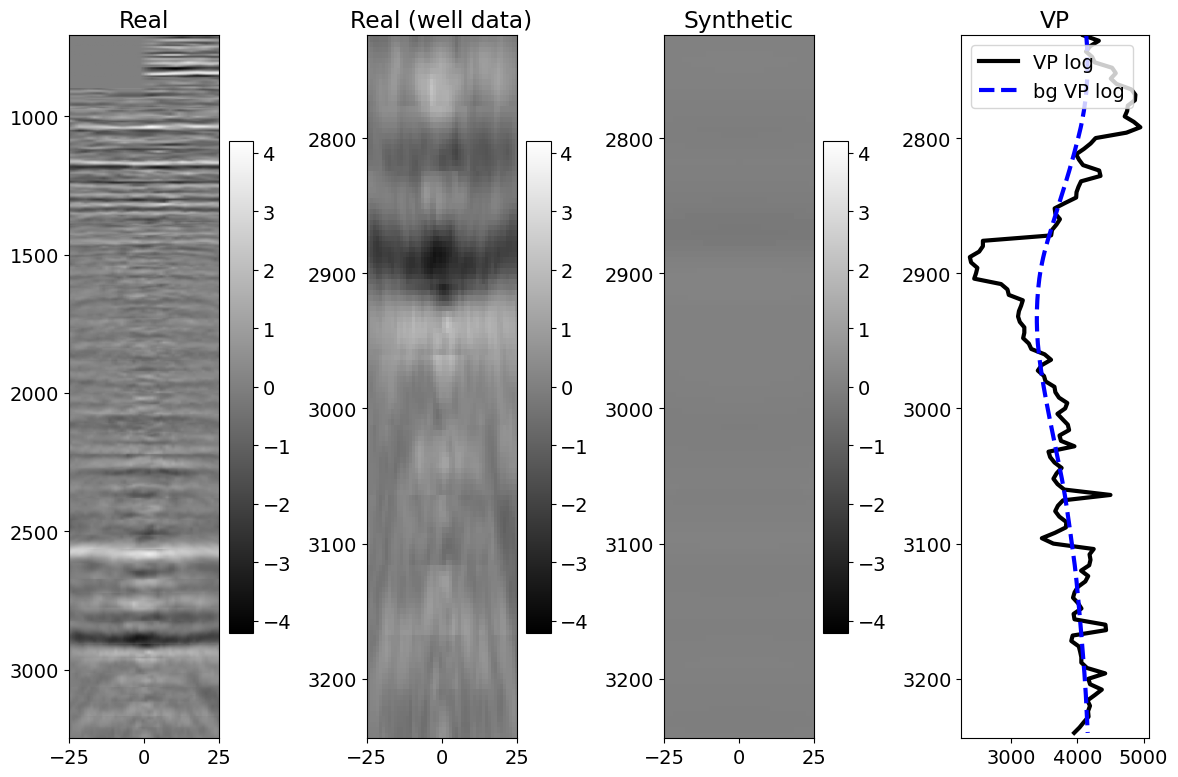

In [106]:
fig  = plot_comparison_gathers_wavelet(well_prestack, synthetic_gather, vp, vp_back, thetamin, 
                                    thetamax, zwell_seismic, z_seismic_prestack_fence, well_start_data,
                                    well_end_data, window_min, window_max)

Let us look at the amplitudes

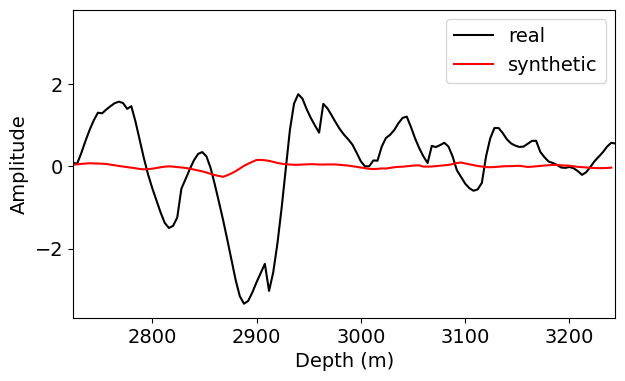

In [107]:
plt.figure(figsize=(7, 4))
plt.plot(zwell_seismic, well_prestack[:, 25], 'k', label='real')
plt.plot(zwell_seismic[well_start_data:well_end_data], synthetic_gather[:, 25], 'r', label='synthetic')
plt.xlim(zwell_seismic[well_start_data], zwell_seismic[well_end_data])
plt.xlabel('Depth (m)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

A shift of the well log is needed to align the well logs wiht the real data

In [108]:
shift_number = 8
synthetic_gather_shifted = shift(synthetic_gather, shift=(shift_number,0), cval=synthetic_gather[0,0])
vp_shifted = shift(vp, shift=(shift_number), cval=vp[0])
vp_back_shifted = shift(vp_back, shift=(shift_number), cval=vp_back[0])

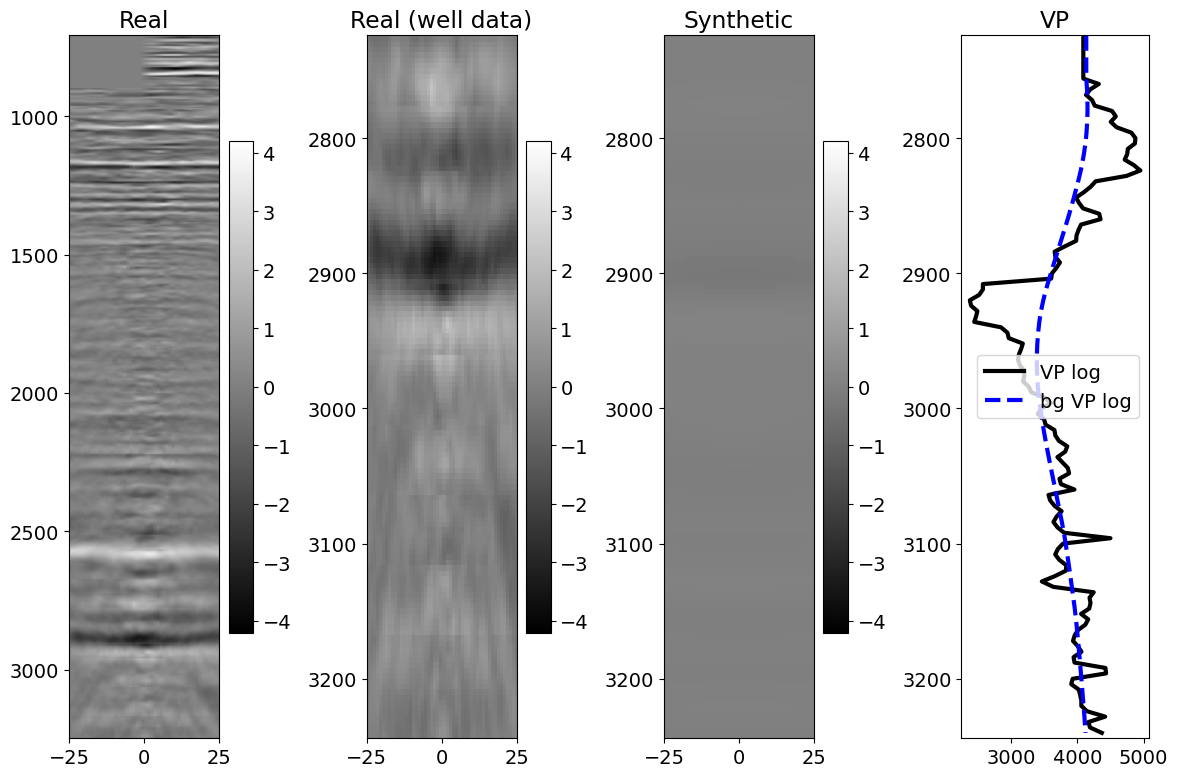

In [109]:
fig  = plot_comparison_gathers_wavelet(well_prestack, synthetic_gather_shifted, vp_shifted, vp_back_shifted, thetamin, 
                                    thetamax, zwell_seismic, z_seismic_prestack_fence, well_start_data,
                                    well_end_data, window_min, window_max)

### Wavelet scaling

Now, we need to find the wavelet scaling

In [110]:
wav_scaling_approx = np.sqrt(np.sum(well_prestack[well_start_data:well_end_data] ** 2) / np.sum(synthetic_gather** 2))
wav_scaling_approx


12.427247473250162

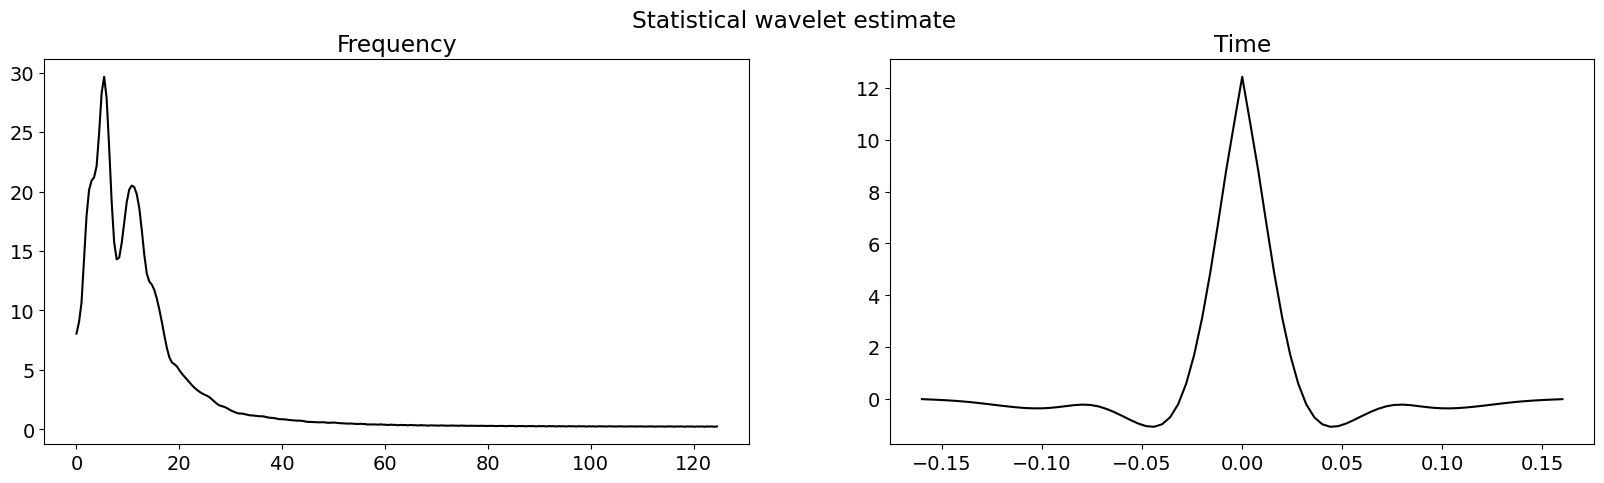

In [111]:
# Statistical Wavelet estimation
nfft = 512
nt_wav = 41
wav_scaling =wav_scaling_approx

wav_est, t_wav ,fwest, wav_est_fft = get_wavelet_estimate(nt_wav=nt_wav, nfft=nfft, wav_scaling=wav_scaling, 
                                    prestack_data=seismicd_prestack_fence[150:300,:, window_min:window_max], 
                                    dt=dt)


# Display wavelet
display_wavelet(wav_est= wav_est, fwest=fwest, wav_est_fft=wav_est_fft, 
                t_wav= t_wav, nfft=nfft, fontsize = 14)

Creting sythetic gather

In [112]:
synthetic_gather = avo_synthetic_gather(vp, vs, rho, wav_est, nt_wav, thetamin=-25, thetamax=25, ntheta=50)

A shift of the well log is needed to align the well logs wiht the real data

In [113]:
shift_number = 9
synthetic_gather_shifted = shift(synthetic_gather, shift=(shift_number,0), cval=synthetic_gather[0,0])
vp_shifted = shift(vp, shift=(shift_number), cval=vp[0])
vp_back_shifted = shift(vp_back, shift=(shift_number), cval=vp_back[0])

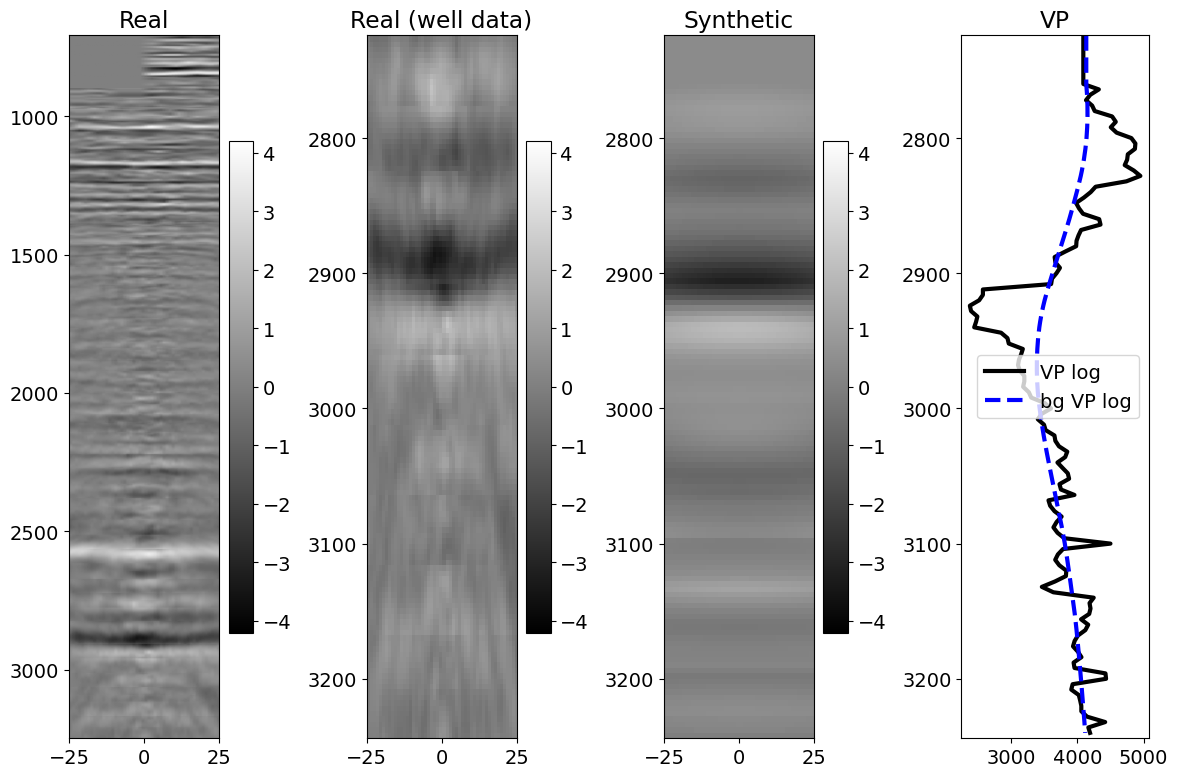

In [116]:
fig  = plot_comparison_gathers_wavelet(well_prestack, synthetic_gather_shifted, vp_shifted, vp_back_shifted, thetamin, 
                                    thetamax, zwell_seismic, z_seismic_prestack_fence, well_start_data,
                                    well_end_data, window_min, window_max)
# fig.savefig('../../figures_results/gather_well_A.png', format='png', dpi=300)

Let us look at the amplitudes

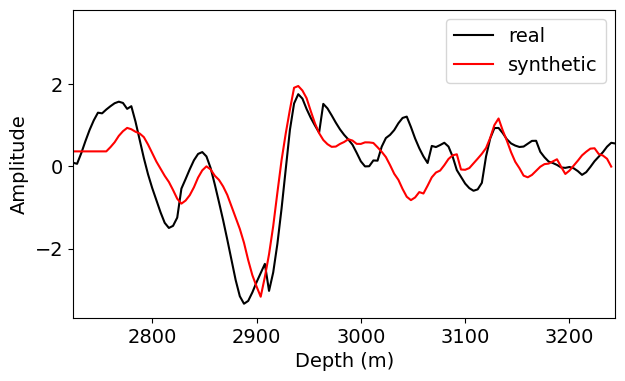

In [115]:
plt.figure(figsize=(7, 4))
plt.plot(zwell_seismic, well_prestack[:, 25], 'k', label='real')
plt.plot(zwell_seismic[well_start_data:well_end_data], synthetic_gather_shifted[:, 25], 'r', label='synthetic')
plt.xlim(zwell_seismic[well_start_data], zwell_seismic[well_end_data])
plt.xlabel('Depth (m)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()